# Relion comparison

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from jax.config import config
from pyem import star
import mrcfile

from simplecryoem.utils import mip_x
from simplecryoem.forwardmodel import project_star_params

In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

### The volume

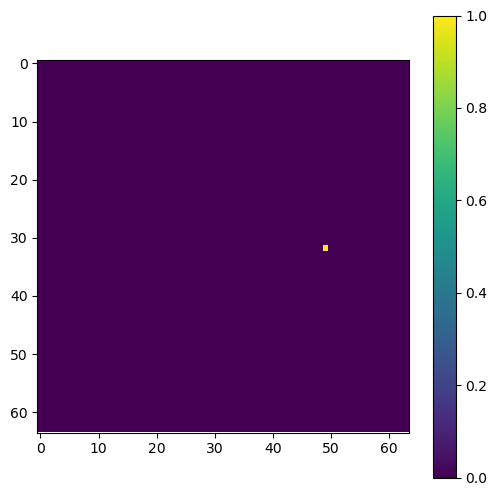

In [3]:
nx = 64
dx = 0.2

vol = np.zeros([nx, nx, nx])
vol[32, 49, 32] = 1

vol_relion = np.zeros([nx, nx, nx])
vol_relion[32, 32, 49] = 1

mip_x(vol_relion)
plt.colorbar()

### Relion projection

Write the volume to file so it can be processed by Relion

In [4]:
# with mrcfile.new('data/pointmass.mrc', overwrite=True) as mrc:
#    mrc.set_data(vol_relion.astype(np.float32))

Then start the Relion Singularity instance on a job on the cluster, go to the data directory and run on of the following:

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj.mrc --ctf false```

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_rot45tilt_shifts.mrc --pad 1 --angpix 1 --rot 45 --tilt 22.5 --xoff 10 --yoff 55```

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_star  --ang pyem_onerow.star  --pad 1 --ctf true```

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_star_pfac2  --ang pyem_onerow.star  --pad 2 --ctf true```

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_star_pfac3  --ang pyem_onerow.star  --pad 3 --ctf true```

Then load the result:

In [5]:
# with mrcfile.open('../tests/data/relion_proj_star.mrcs') as mrc:
with mrcfile.open("data/relion_proj_star_pfac2.mrcs") as mrc:
    # with mrcfile.open('../tests/data/relion_proj_star_pfac3.mrcs') as mrc:
    proj_relion = mrc.data

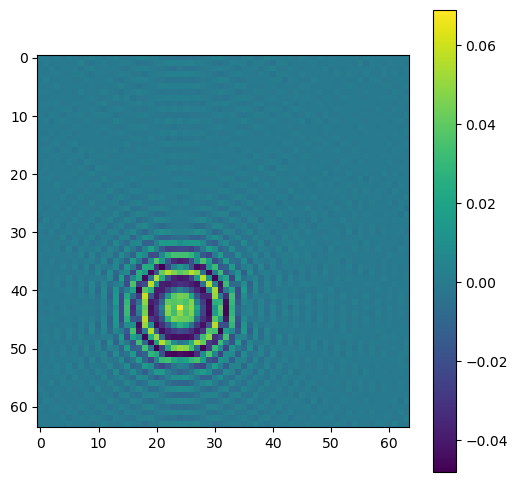

In [6]:
plt.imshow(proj_relion)
plt.colorbar()

### simplecryoem projection

In [7]:
df = star.parse_star("data/pyem_onerow.star", keep_index=False)
dfiter = df.iterrows()
i, p = next(dfiter)

Parameters from the star file

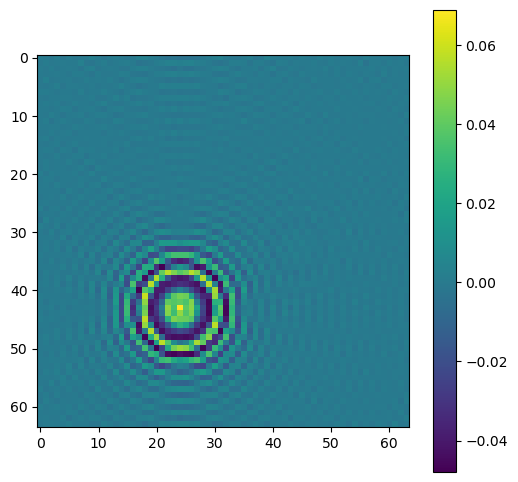

In [8]:
proj = project_star_params(vol, p, pfac=2)
plt.imshow(proj)
plt.colorbar()

### Compare

In [9]:
f2d = np.fft.fftshift(np.fft.fftn(proj))
f2d_relion = np.fft.fftshift(np.fft.fftn(proj_relion))

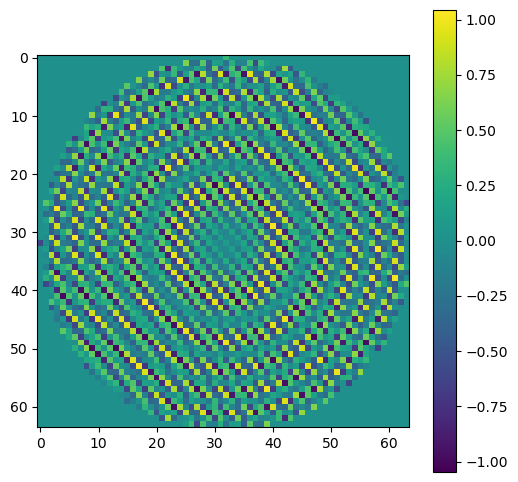

In [10]:
plt.imshow(np.real(f2d))
plt.colorbar()

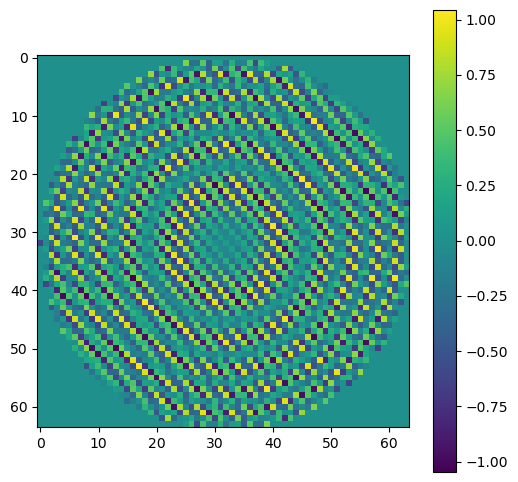

In [11]:
plt.imshow(np.real(f2d_relion))
plt.colorbar()

0.3557882589657553

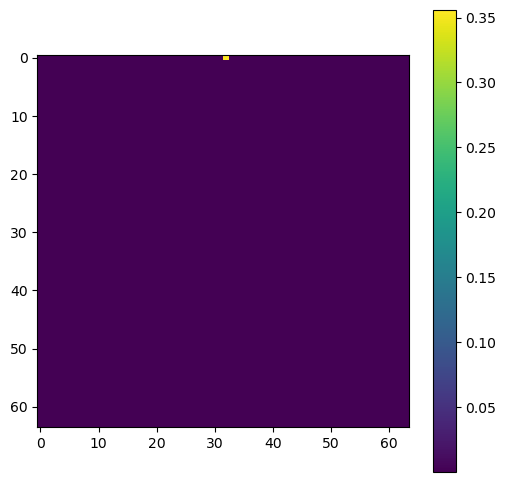

In [12]:
diff = f2d - f2d_relion
plt.imshow(np.abs(diff))
plt.colorbar()
np.max(np.abs(diff))

3.939056671205135e-08

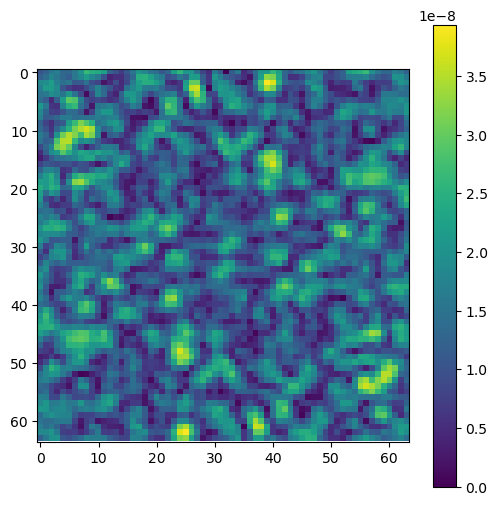

In [13]:
diff[np.abs(diff) > 0.35] = 0
plt.imshow(np.abs(diff))
plt.colorbar()
np.max(np.abs(diff))

### Batch comparison

Run relion on multiple orientations etc:

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_batch  --ang data/pyem.star  --pad 1 --ctf true```

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_batch_pfac2  --ang data/pyem.star  --pad 2 --ctf true```

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_batch_pfac3  --ang data/pyem.star  --pad 3 --ctf true```

Then load the file:

In [14]:
# with mrcfile.open('data/relion_proj_batch.mrcs') as mrc:
with mrcfile.open("data/relion_proj_batch_pfac2.mrcs") as mrc:
    # with mrcfile.open('data/relion_proj_batch_pfac3.mrcs') as mrc:
    proj_relion = mrc.data

In [15]:
df = star.parse_star("data/pyem.star", keep_index=False)
dfiter = df.iterrows()
# i, p = next(dfiter)

In [16]:
proj = np.array([project_star_params(vol, p, pfac=2) for (i, p) in dfiter])

In [17]:
f2d = np.array([np.fft.fftshift(np.fft.fftn(p)) for p in proj])
f2d_relion = np.array([np.fft.fftshift(np.fft.fftn(p)) for p in proj_relion])

In [18]:
diff = f2d - f2d_relion
np.sum(np.abs(diff) > 0.001)

27

In [19]:
diff[np.abs(diff) > 0.001] = 0
np.max(np.abs(diff))

5.295793862505502e-08

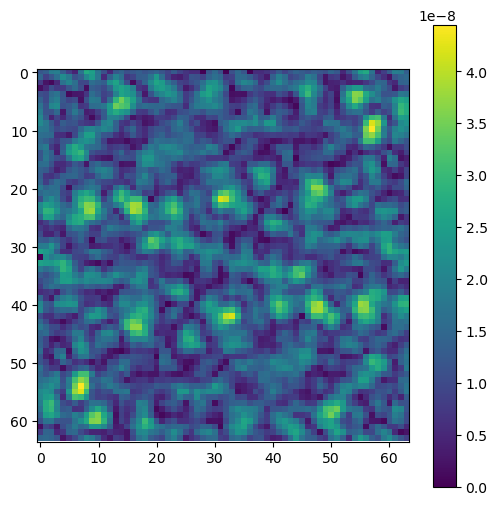

In [20]:
plt.imshow(np.abs(diff[5]))
plt.colorbar()